In [ ]:
# load afm423_finratio_data.csv as data frame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

# Dont show warnings
import warnings
warnings.filterwarnings("ignore")

## Data

- Here is a list of all the features in this dataset, along with the formula used: https://wrds-www.wharton.upenn.edu/documents/793/WRDS_Industry_Financial_Ratio_Manual.pdf
- The financial ratios data is loaded into `df` and the column/feature names along with their description and category are loaded into `df_columns`.
- There are 70 features spread across 7 categories: `Capitalization`, `Efficiency`, `Financial Soundness/Solvency`, `Liquidity`, `Profitability`, `Valuation`, and `Others`.

In [2]:
# Load the data
df = pd.read_csv('afm423_finratio_data.csv')

# Rename columns
df.rename(columns={
    'public_date': 'date'
}, inplace=True)

# Convert data types
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['gvkey'] = pd.to_numeric(df['gvkey'], errors='coerce')

# Load column names info
df_columns = pd.read_csv('afm423_finratio_columns.csv')

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'afm423_finratio_data.csv'

#### Data Visualization

- We see that to get rectangular data, we will need to choose a smaller timeframe. Hoping to keep more than half the companies of the current `S&P 1500` constituents and at least 25 years of data, we chose to keep data from Jan 2000 to Dec 2024.

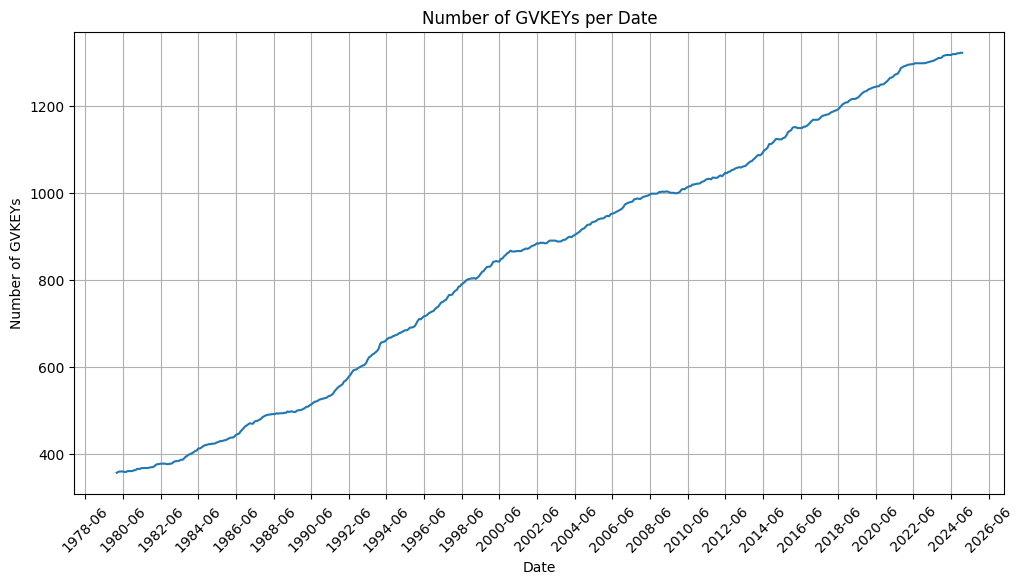

,date,number_of_gvkeys


In [ ]:
# Plot the number of gvkeys per date
gvkey_counts = df.groupby('date')['gvkey'].nunique().reset_index()  # Count the number of unique gvkeys for each date
gvkey_counts.columns = ['date', 'number_of_gvkeys']                 # Rename columns for clarity

plt.figure(figsize=(12, 6))
plt.plot(gvkey_counts['date'], gvkey_counts['number_of_gvkeys'])
plt.xlabel('Date')
plt.ylabel('Number of GVKEYs')
plt.title('Number of GVKEYs per Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.grid()
plt.show()

# Set the cutoff date to 2000-01-01
cutoff_date = pd.to_datetime('2000-01-01')
gvkey_counts[gvkey_counts['date'] == cutoff_date]

In [108]:
# Filter the data for the year 1998 onwards
df = df[df['date'] > cutoff_date]

# Keep only the companies with full data (i.e., 300 months of data)
df = df[df['gvkey'].isin(df['gvkey'].value_counts()[df['gvkey'].value_counts() == 300].index)]

# Remove gvkeys that have more than 1 permno (as this means we don't actually have full data for the stock, there are multiple stocks/classes)
gvkey_permno_counts = df.groupby('gvkey')['permno'].nunique()
gvkey_permno_counts = gvkey_permno_counts[gvkey_permno_counts > 1].index.tolist()
print(f"Gvkeys with more than 1 permno: {gvkey_permno_counts}")
df = df[~df['gvkey'].isin(gvkey_permno_counts)]

# Check the number of gvkeys and the number of months
print(f"Number of gvkeys: {df['gvkey'].nunique()}")
print(f"Number of months: {df['date'].nunique()}")

df

Gvkeys with more than 1 permno: [1076, 2176, 3226, 3580, 3708, 4060, 4723, 4809, 4818, 10121, 12441, 25536, 26061, 28194, 30861, 63000, 64410, 65009, 65228, 126423]
Number of gvkeys: 752
Number of months: 300


,gvkey,permno,adate,qdate,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,PEG_1yrforward,PEG_ltgforward,TICKER,cusip
240,1004,54594,1999-05-31,1999-11-30,2000-01-31,18.333,0.858,6.916,11.055,11.195,...,0.0,0.0,0.036,1.250,0.427,1.92%,0.920,0.730,AIR,00036110
241,1004,54594,1999-05-31,1999-11-30,2000-02-29,24.617,0.858,6.916,14.844,15.032,...,0.0,0.0,0.036,1.678,0.574,1.43%,1.308,0.980,AIR,00036110
242,1004,54594,1999-05-31,1999-11-30,2000-03-31,17.296,0.858,6.916,10.430,10.562,...,0.0,0.0,0.036,1.179,0.403,2.04%,0.976,0.689,AIR,00036110
243,1004,54594,1999-05-31,2000-02-29,2000-04-30,14.516,0.617,7.390,9.241,9.356,...,0.0,0.0,0.047,1.028,0.396,2.26%,0.922,0.645,AIR,00036110
244,1004,54594,1999-05-31,2000-02-29,2000-05-31,13.372,0.617,7.390,8.512,8.618,...,0.0,0.0,0.047,0.947,0.365,2.45%,0.909,0.594,AIR,00036110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401562,126721,87445,2023-12-31,2024-06-30,2024-08-31,34.479,0.534,17.115,25.932,26.278,...,0.0,0.0,-0.012,2.082,0.937,NaN,-17.823,NaN,TDY,87936010
401563,126721,87445,2023-12-31,2024-06-30,2024-09-30,34.866,0.534,17.115,26.223,26.573,...,0.0,0.0,-0.012,2.105,0.948,NaN,-18.023,NaN,TDY,87936010
401564,126721,87445,2023-12-31,2024-06-30,2024-10-31,36.132,0.534,17.115,27.281,27.645,...,0.0,0.0,-0.012,2.181,0.986,NaN,-18.750,NaN,TDY,87936010
401565,126721,87445,2023-12-31,2024-09-30,2024-11-30,36.737,0.489,17.187,29.057,29.410,...,0.0,0.0,-0.006,2.265,0.928,NaN,-19.342,NaN,TDY,87936010


#### Handling Missing Values

- Here we visualize the missing values using a `heatmap` and see that there are many missing values throughout the dataset, with some columns having more NAs than others.
- We want to remove any column/variable that is missing more than 15% of the data in our timeframe, so we remove the columns `PEG_trailing`, `sale_nwc`, `divyield`, `PEG_ltgforward`, `cash_conversion`, `int_debt`, `invt_act`, `int_totdebt`, `pretret_earnat`, `pretret_noa`, `rect_act`, `ocf_lct`, `curr_debt`, `profit_lct`, `curr_ratio`, `cash_ratio`, `quick_ratio`, `intcov_ratio`, `intcov`, and `inv_turn`.
- Can also drop `adate` and `qdate` as these are simply the company's year end and quarter end dates, and `public_date` is the date for that entry.
- We have identifiers `gvkey` and `permno`, so we can remove `TICKER` and `cusip` for now.

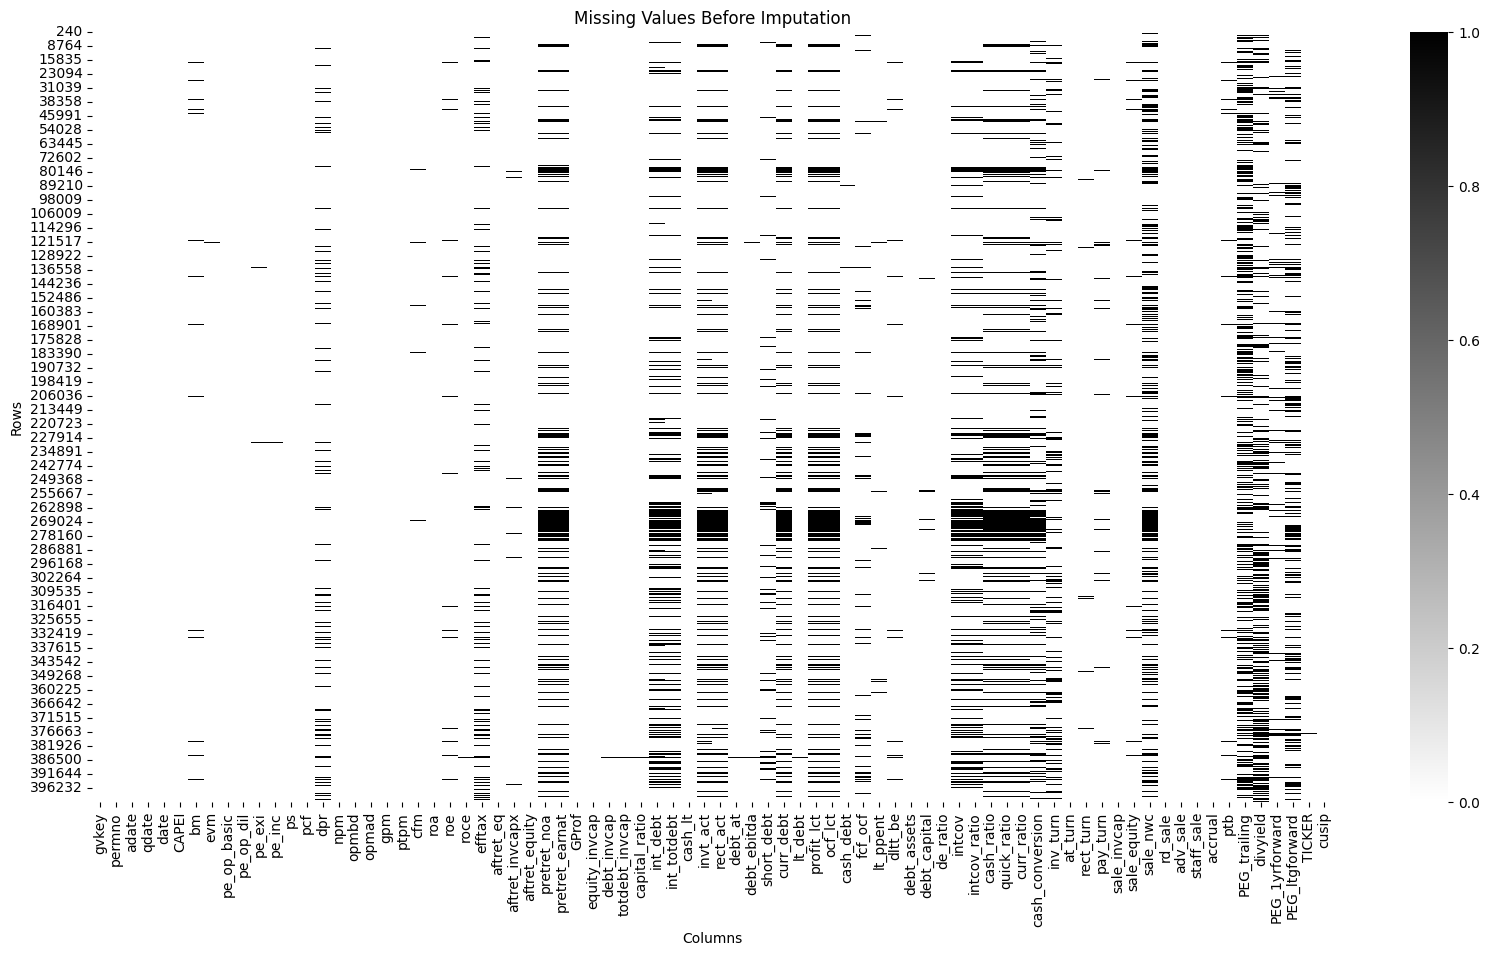


Missing Values Before Imputation:
        Column Name  Missing Values    Percent
0      PEG_trailing           79173  35.094415
1          sale_nwc           67938  30.114362
2          divyield           65700  29.122340
3    PEG_ltgforward           55854  24.757979
4   cash_conversion           47505  21.057181
5          int_debt           45083  19.983599
6          invt_act           42962  19.043440
7       int_totdebt           42843  18.990691
8    pretret_earnat           41201  18.262855
9       pretret_noa           41201  18.262855
10         rect_act           41062  18.201241
11          ocf_lct           40847  18.105940
12        curr_debt           40759  18.066933
13       profit_lct           40688  18.035461
14       curr_ratio           40672  18.028369
15       cash_ratio           40672  18.028369
16      quick_ratio           40672  18.028369
17     intcov_ratio           39362  17.447695
18           intcov           39353  17.443706
19         inv_turn      

,gvkey,permno,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward
240,1004,54594,2000-01-31,18.333,0.858,6.916,11.055,11.195,11.195,11.195,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.250,0.920
241,1004,54594,2000-02-29,24.617,0.858,6.916,14.844,15.032,15.032,15.032,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.678,1.308
242,1004,54594,2000-03-31,17.296,0.858,6.916,10.430,10.562,10.562,10.562,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.179,0.976
243,1004,54594,2000-04-30,14.516,0.617,7.390,9.241,9.356,9.356,9.356,...,6.570,7.764,2.064,3.176,0.000,0.0,0.0,0.047,1.028,0.922
244,1004,54594,2000-05-31,13.372,0.617,7.390,8.512,8.618,8.618,8.618,...,6.570,7.764,2.064,3.176,0.000,0.0,0.0,0.047,0.947,0.909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401562,126721,87445,2024-08-31,34.479,0.534,17.115,25.932,26.278,23.535,23.535,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.082,-17.823
401563,126721,87445,2024-09-30,34.866,0.534,17.115,26.223,26.573,23.799,23.799,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.105,-18.023
401564,126721,87445,2024-10-31,36.132,0.534,17.115,27.281,27.645,24.759,24.759,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.181,-18.750
401565,126721,87445,2024-11-30,36.737,0.489,17.187,29.057,29.410,24.558,24.558,...,4.653,7.485,0.464,0.597,0.065,0.0,0.0,-0.006,2.265,-19.342


In [109]:
def missing_values_check(data, title):
    """
    This function checks for missing values in the data frame and returns a table with the number and percent of missing values.
    """
    # give a table of the column name with number and percent of missing values in each column
    missing_values = data.isnull().sum()
    missing_values_percent = (missing_values / len(data)) * 100
    missing_values_table = pd.DataFrame({'Missing Values': missing_values, 'Percent': missing_values_percent})
    missing_values_table = missing_values_table[missing_values_table['Missing Values'] > 0]
    missing_values_table = missing_values_table.sort_values(by='Missing Values', ascending=False)
    missing_values_table.reset_index(inplace=True)
    missing_values_table.columns = ['Column Name', 'Missing Values', 'Percent']
    missing_values_table = missing_values_table[['Column Name', 'Missing Values', 'Percent']]
    missing_values_table.reset_index(drop=True, inplace=True)

    print(f"\n{title}:")
    print("==============================================")
    print(missing_values_table.head(20))
    return missing_values_table

# Check for missing values
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=True, cmap='binary')
plt.title("Missing Values Before Imputation")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

missing_values_table = missing_values_check(df, "Missing Values Before Imputation")

# Drop columns with more than 20% missing values
columns_to_drop = missing_values_table[missing_values_table['Percent'] > 15]['Column Name'].tolist()
columns_to_drop.append('adate')
columns_to_drop.append('qdate')
columns_to_drop.append('TICKER')
columns_to_drop.append('cusip')
df.drop(columns=columns_to_drop, inplace=True)
df

In [110]:
# Get all feature names
columns = df.columns[3:].tolist()

# Sort by firm and date
df = df.sort_values(by=['gvkey', 'date'])

# List of ratio columns to impute using rolling 18-month average (all columns except 'gvkey', 'date', and 'permno')
ratio_cols = columns

# Apply rolling 18-month average imputation for each firm
for i in range(5):
    for col in ratio_cols:
        df[col] = df.groupby('gvkey')[col].transform(
            lambda x: x.fillna(x.rolling(window=18, min_periods=1).mean())
        )

# Fill any remaining NaN values with the median of the column per gvkey
for col in ratio_cols:
    df[col] = df.groupby('gvkey')[col].transform(
        lambda x: x.fillna(x.median())
    )

# The remaing NaN values are only for companies that have no data for that column, so we can drop these rows
df.dropna(inplace=True)

# Check for missing values again
missing_values_check(df, "Missing Values After Imputation")

df


Missing Values After Imputation:
Empty DataFrame
Columns: [Column Name, Missing Values, Percent]
Index: []


,gvkey,permno,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward
240,1004,54594,2000-01-31,18.333,0.858,6.916,11.055,11.195,11.195,11.195,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.250,0.920
241,1004,54594,2000-02-29,24.617,0.858,6.916,14.844,15.032,15.032,15.032,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.678,1.308
242,1004,54594,2000-03-31,17.296,0.858,6.916,10.430,10.562,10.562,10.562,...,6.605,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.179,0.976
243,1004,54594,2000-04-30,14.516,0.617,7.390,9.241,9.356,9.356,9.356,...,6.570,7.764,2.064,3.176,0.000,0.0,0.0,0.047,1.028,0.922
244,1004,54594,2000-05-31,13.372,0.617,7.390,8.512,8.618,8.618,8.618,...,6.570,7.764,2.064,3.176,0.000,0.0,0.0,0.047,0.947,0.909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401562,126721,87445,2024-08-31,34.479,0.534,17.115,25.932,26.278,23.535,23.535,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.082,-17.823
401563,126721,87445,2024-09-30,34.866,0.534,17.115,26.223,26.573,23.799,23.799,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.105,-18.023
401564,126721,87445,2024-10-31,36.132,0.534,17.115,27.281,27.645,24.759,24.759,...,4.684,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.181,-18.750
401565,126721,87445,2024-11-30,36.737,0.489,17.187,29.057,29.410,24.558,24.558,...,4.653,7.485,0.464,0.597,0.065,0.0,0.0,-0.006,2.265,-19.342


#### Returns Data

- Load in CRSP returns data and roll back the date to previous month end to be used as merging key (so month t's financials are matched with month (t+1)'s returns for the training).
- Merge cleaned returns data into df, finally giving us 51 features and 743 companies (total 229000 entries) with no NAs and no duplicates.

In [111]:
# Import the data from the csv file
returns = pd.read_csv('afm423_returns.csv')

# Rename columns
returns.rename(columns={
    'datadate': 'date'
}, inplace=True)

# Convert data types
returns['date'] = pd.to_datetime(returns['date'], format='%Y-%m-%d')
returns['LPERMNO'] = pd.to_numeric(returns['LPERMNO'], errors='coerce')

# Roll date to previous month to be used as merging key (so month t's financials are matched with month (t+1)'s returns)
returns['date_merge'] = returns['date'].dt.to_period('M').dt.to_timestamp()
returns['date_merge'] = returns['date_merge'] - pd.DateOffset(days=1)

# Sort by datadate and gvkey
returns = returns[['LPERMNO', 'date_merge', 'trt1m']]
returns = returns[returns['date_merge'] > cutoff_date]
returns = returns[returns['date_merge'] < pd.to_datetime('2025-01-01')]
returns.sort_values(by=['LPERMNO', 'date_merge'], inplace=True)
returns.reset_index(drop=True, inplace=True)

missing_values_check(returns, "Missing Values In Returns Data")

# Fill na values with 0
returns['trt1m'] = returns['trt1m'].fillna(0)

returns


Missing Values In Returns Data:
  Column Name  Missing Values   Percent
0       trt1m             519  0.141343


,LPERMNO,date_merge,trt1m
0,10026,2000-01-31,-3.5948
1,10026,2000-02-29,7.7966
2,10026,2000-03-31,-19.8113
3,10026,2000-04-30,-6.6667
4,10026,2000-05-31,20.1681
...,...,...,...
367188,93436,2024-08-31,22.1942
367189,93436,2024-09-30,-4.5025
367190,93436,2024-10-31,38.1469
367191,93436,2024-11-30,17.0008


In [112]:
# Merge the returns data with the financial ratios data
df = pd.merge(df, returns, how='left', left_on=['permno', 'date'], right_on=['LPERMNO', 'date_merge'])
df.drop(columns=['LPERMNO', 'date_merge'], inplace=True)

# Check for missing values again
missing_values_check(df, "Missing Values After Merging with Returns")

df


Missing Values After Merging with Returns:
Empty DataFrame
Columns: [Column Name, Missing Values, Percent]
Index: []


,gvkey,permno,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,trt1m
0,1004,54594,2000-01-31,18.333,0.858,6.916,11.055,11.195,11.195,11.195,...,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.250,0.920,34.2756
1,1004,54594,2000-02-29,24.617,0.858,6.916,14.844,15.032,15.032,15.032,...,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.678,1.308,-29.7368
2,1004,54594,2000-03-31,17.296,0.858,6.916,10.430,10.562,10.562,10.562,...,7.412,2.045,3.165,0.000,0.0,0.0,0.036,1.179,0.976,-9.2285
3,1004,54594,2000-04-30,14.516,0.617,7.390,9.241,9.356,9.356,9.356,...,7.764,2.064,3.176,0.000,0.0,0.0,0.047,1.028,0.922,-7.8838
4,1004,54594,2000-05-31,13.372,0.617,7.390,8.512,8.618,8.618,8.618,...,7.764,2.064,3.176,0.000,0.0,0.0,0.047,0.947,0.909,-13.5135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222895,126721,87445,2024-08-31,34.479,0.534,17.115,25.932,26.278,23.535,23.535,...,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.082,-17.823,1.1229
222896,126721,87445,2024-09-30,34.866,0.534,17.115,26.223,26.573,23.799,23.799,...,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.105,-18.023,4.0351
222897,126721,87445,2024-10-31,36.132,0.534,17.115,27.281,27.645,24.759,24.759,...,7.358,0.468,0.607,0.066,0.0,0.0,-0.012,2.181,-18.750,6.5756
222898,126721,87445,2024-11-30,36.737,0.489,17.187,29.057,29.410,24.558,24.558,...,7.485,0.464,0.597,0.065,0.0,0.0,-0.006,2.265,-19.342,-4.3544


In [113]:
# Export the data to a csv file
# df.to_csv('afm423_final_data.csv', index=False)

## Feature Engineering

1. Loading the final dataset
2. Creating 'month' and 'year' variables
3. Winsorize outliers
4. Removing highly collinear features

In [171]:
final_df = pd.read_csv('afm423_final_data.csv')
final_df['date'] = pd.to_datetime(final_df['date'], format='%Y-%m-%d')
final_df['month'] = final_df['date'].dt.month
final_df['year'] = final_df['date'].dt.year
df = final_df.copy()

In [173]:
final_df.describe()

,gvkey,permno,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,trt1m,month,year
count,222900.000000,222900.000000,222900,222900.000000,222900.000000,2.229000e+05,222900.000000,222900.000000,222900.000000,222900.000000,...,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.00000,222900.000000
mean,23461.080754,57268.314939,2012-07-15 12:47:59.999999744,17.076722,0.545994,-1.383236e+00,16.670644,16.903164,16.494780,15.933710,...,5.955906,0.398639,0.011084,0.065992,-0.044748,3.904428,0.420726,1.358512,6.50000,2012.000000
min,1004.000000,10026.000000,2000-01-31 00:00:00,-599721.000000,0.000000,-1.110000e+06,-8580.600000,-8155.300000,-7909.100000,-7812.600000,...,0.000000,0.000000,0.000000,0.000000,-4.233000,0.056000,-239.850000,-83.480700,1.00000,2000.000000
25%,6223.000000,29612.000000,2006-04-22 12:00:00,14.418000,0.267000,8.047000e+00,9.934000,10.124000,9.468000,9.211000,...,0.973000,0.000000,0.000000,0.000000,-0.070000,1.403000,-0.280000,-4.236100,3.75000,2006.000000
50%,11399.000000,65306.000000,2012-07-15 12:00:00,21.607000,0.450000,1.055400e+01,15.902000,16.140000,16.334000,16.099000,...,1.768000,0.000000,0.000000,0.000000,-0.038000,2.254000,0.575000,1.138650,6.50000,2012.000000
75%,27794.000000,80320.000000,2018-10-07 18:00:00,32.526000,0.716000,1.428000e+01,22.938000,23.330000,24.476000,24.291000,...,3.157000,0.026000,0.010000,0.000000,-0.010000,3.824000,1.785103,6.438800,9.25000,2018.000000
max,126721.000000,92655.000000,2024-12-31 00:00:00,109856.000000,32.743000,4.453360e+04,1146.250000,1107.810000,1216.250000,1173.000000,...,15681.800000,12958.000000,1.932000,14.366000,0.773000,114.149000,43.110000,358.883200,12.00000,2024.000000
std,28916.162814,26607.047463,NaN,2206.477213,0.500791,4.082710e+03,82.816768,86.182004,91.055105,90.414805,...,85.371131,49.866639,0.030196,0.267403,0.077599,6.601128,7.735254,11.102517,3.45206,7.211119


In [174]:
# Winsorize the features (except for date , gvkey, permno, and returns)
def winsorize_series(s, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = s.quantile(lower_percentile)
    upper_bound = s.quantile(upper_percentile)
    return np.clip(s, lower_bound, upper_bound)

# Apply winsorization to all columns except 'date', 'gvkey', 'permno', and 'trt1m'
for col in final_df.columns[3:]:
    if col not in ['date', 'gvkey', 'permno', 'trt1m']:
        final_df[col] = winsorize_series(final_df[col], lower_percentile=0.01, upper_percentile=0.99)

final_df.describe()

,gvkey,permno,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_1yrforward,trt1m,month,year
count,222900.000000,222900.000000,222900,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,...,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.000000,222900.00000,222900.000000
mean,23461.080754,57268.314939,2012-07-15 12:47:59.999999744,25.820008,0.533642,12.200369,18.076772,18.402119,18.148633,17.709254,...,3.369590,0.032045,0.010468,0.057969,-0.043702,3.728757,0.597182,1.358512,6.50000,2012.000000
min,1004.000000,10026.000000,2000-01-31 00:00:00,-175.400300,0.021000,-40.040860,-114.880800,-117.220300,-167.220500,-175.001700,...,0.265000,0.000000,0.000000,0.000000,-0.254000,0.450000,-26.507060,-83.480700,1.00000,2000.000000
25%,6223.000000,29612.000000,2006-04-22 12:00:00,14.418000,0.267000,8.047000,9.934000,10.124000,9.468000,9.211000,...,0.973000,0.000000,0.000000,0.000000,-0.070000,1.403000,-0.280000,-4.236100,3.75000,2006.000000
50%,11399.000000,65306.000000,2012-07-15 12:00:00,21.607000,0.450000,10.554000,15.902000,16.140000,16.334000,16.099000,...,1.768000,0.000000,0.000000,0.000000,-0.038000,2.254000,0.575000,1.138650,6.50000,2012.000000
75%,27794.000000,80320.000000,2018-10-07 18:00:00,32.526000,0.716000,14.280000,22.938000,23.330000,24.476000,24.291000,...,3.157000,0.026000,0.010000,0.000000,-0.010000,3.824000,1.785103,6.438800,9.25000,2018.000000
max,126721.000000,92655.000000,2024-12-31 00:00:00,271.341760,2.008000,73.237000,178.017780,182.205170,217.438460,217.877920,...,55.397070,0.447000,0.133000,0.596000,0.122000,38.159000,22.158000,358.883200,12.00000,2024.000000
std,28916.162814,26607.047463,NaN,45.487157,0.372481,11.727374,29.662531,30.262278,38.437871,39.033944,...,6.707799,0.072828,0.023108,0.129538,0.056910,5.190602,5.409315,11.102517,3.45206,7.211119


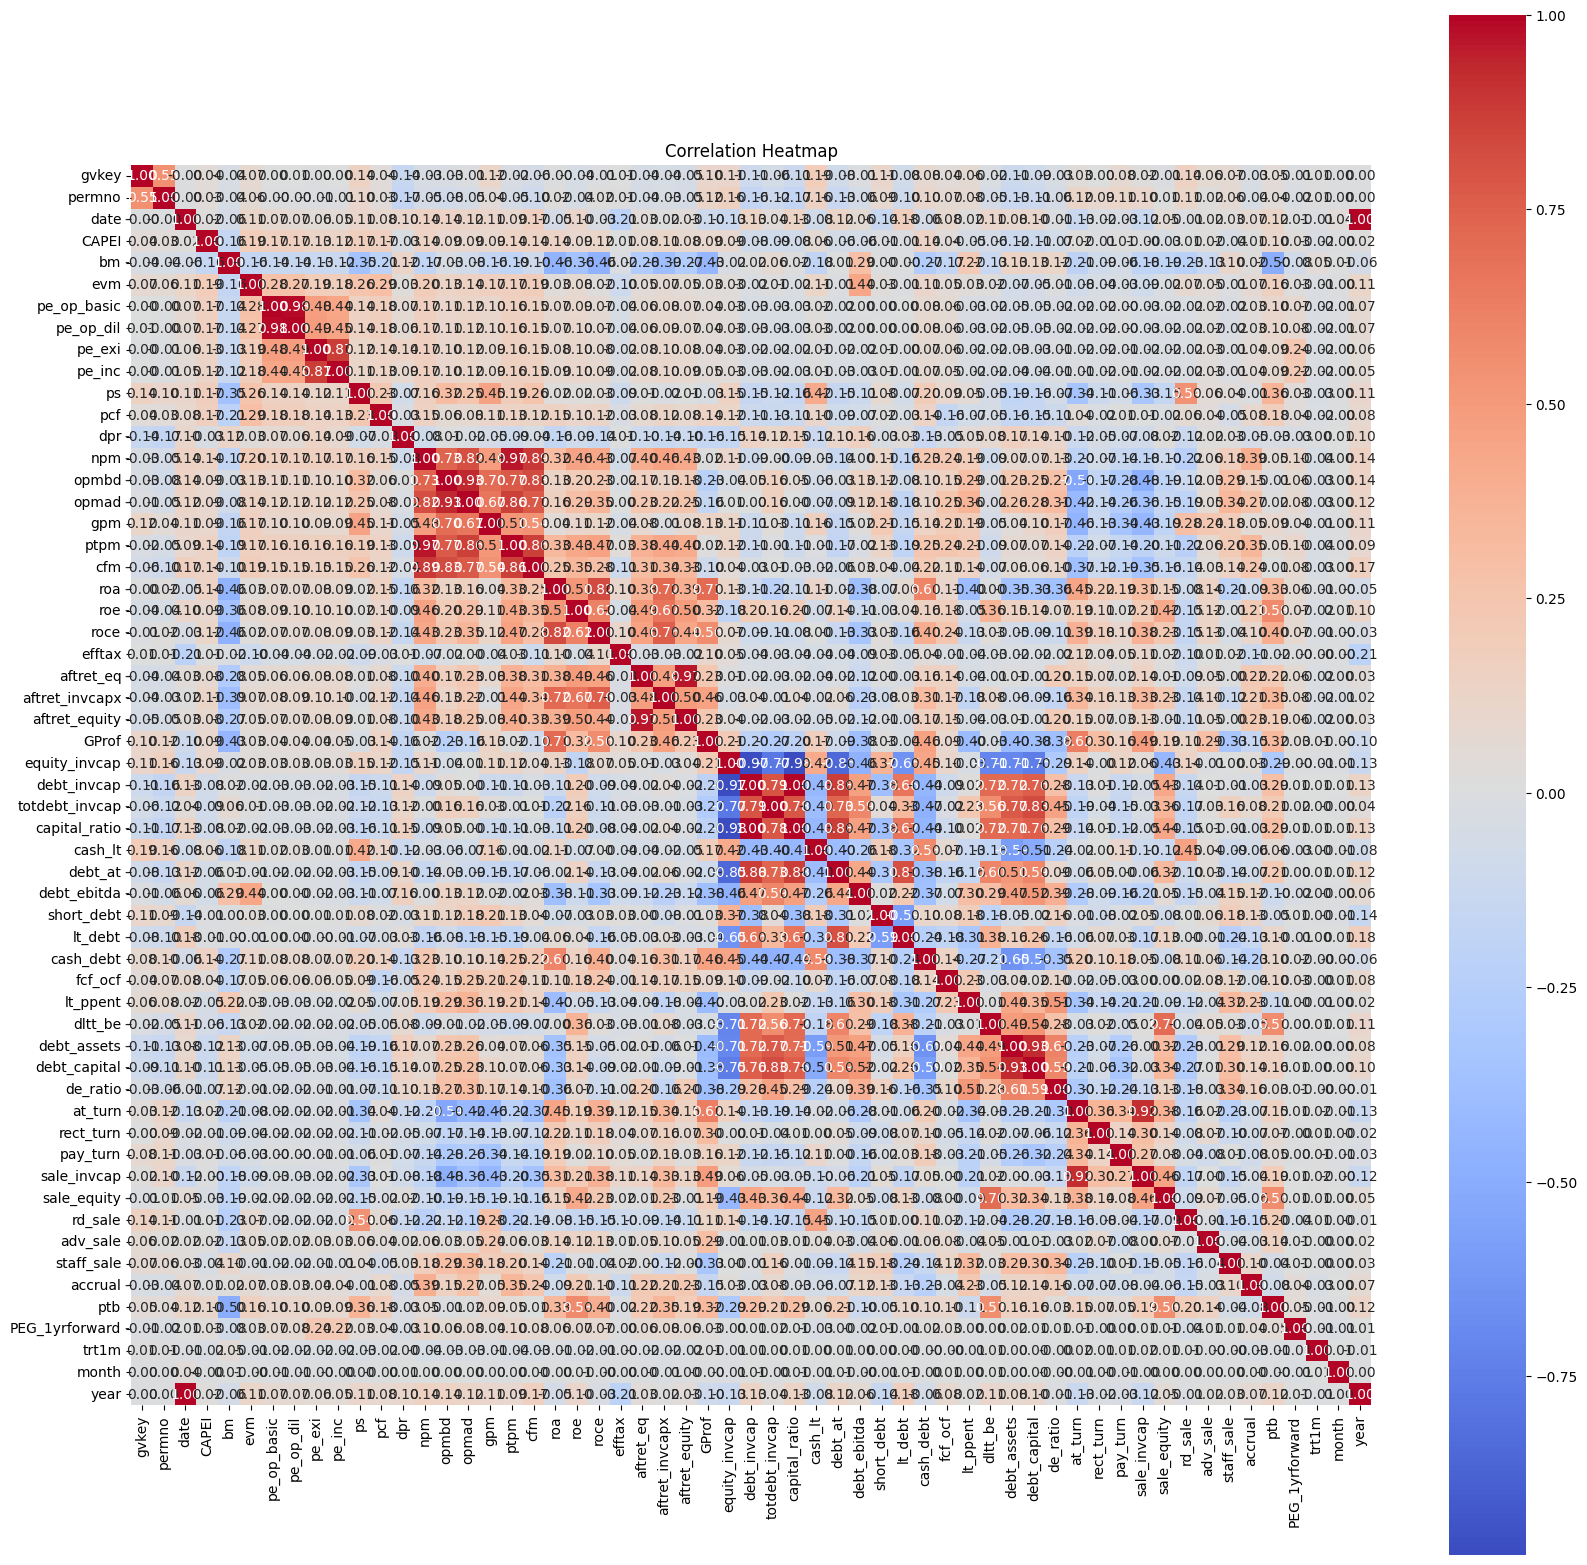

In [175]:
# Correlation heatmap for features
plt.figure(figsize=(20, 20))
sns.heatmap(final_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [176]:
# Remove features with correlation above abs(0.7) and keep only the first one
corr_matrix = final_df.corr().abs()
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]
high_corr_pairs = corr_pairs[corr_pairs > 0.7]
high_corr_pairs = high_corr_pairs.reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] < high_corr_pairs['Feature 2']]
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)
high_corr_pairs = high_corr_pairs.reset_index(drop=True)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.7]
high_corr_pairs = high_corr_pairs[['Feature 1', 'Feature 2']]
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Feature 1'])
high_corr_pairs = high_corr_pairs.reset_index(drop=True)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] != high_corr_pairs['Feature 2']]
high_corr_pairs = high_corr_pairs[['Feature 1']]
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Feature 1'])
high_corr_pairs = high_corr_pairs.reset_index(drop=True)
high_corr_pairs = high_corr_pairs['Feature 1'].tolist()
print(f"Number of features with correlation above 0.7: {len(high_corr_pairs)}")
# Drop the features with correlation above 0.5
final_df.drop(columns=high_corr_pairs, inplace=True)
# Check the number of features
print(f"Number of features after dropping correlated features: {len(final_df.columns)}")



Number of features with correlation above 0.7: 20
Number of features after dropping correlated features: 37


In [177]:
# df = final_df.copy()
# df = df.drop(columns=['gvkey', 'permno', 'date'])

y_raw = final_df['trt1m'].values.reshape(-1, 1)


target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_raw).flatten()


feature_df = final_df.drop(columns=['gvkey', 'permno', 'trt1m'])
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(feature_df)


scaled_df = pd.DataFrame(X_scaled, columns=feature_df.columns)
scaled_df['trt1m'] = y_scaled
scaled_df['date'] = df['date'] 


train_df = scaled_df[scaled_df['date'] <= '2019-12-31']
test_df = scaled_df[scaled_df['date'] > '2019-12-31']

train_X = train_df.drop(columns=['trt1m', 'date']).values
train_y = train_df['trt1m'].values
# Winsorize only train_y
train_y = winsorize_series(pd.Series(train_y), lower_percentile=0.01, upper_percentile=0.99).values
test_X = test_df.drop(columns=['trt1m', 'date']).values
test_y = test_df['trt1m'].values


train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print("Train shape:", train_X.shape, train_y.shape)
print("Test shape:", test_X.shape, test_y.shape)


Train shape: (178320, 1, 34) (178320,)
Test shape: (44580, 1, 34) (44580,)


## Modeling

### XGBoost

In [187]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def XGBoost_Regression(train_X, train_y, test_X, test_y, feature_names=None, plot_importance=False):
    # Flatten if input has shape (n, 1, f)
    if train_X.ndim == 3:
        train_X = train_X.reshape(train_X.shape[0], train_X.shape[2])
        test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

    # Convert to DMatrix
    dtrain = xgb.DMatrix(train_X, label=train_y, feature_names=feature_names)
    dtest = xgb.DMatrix(test_X, label=test_y, feature_names=feature_names)

    # Define XGBoost regression parameters
    params = {
        'objective': 'reg:squarederror',  # regression task
        'eval_metric': 'rmse',
        'subsample': 0.8,
        'eta': 0.05,
        'max_depth': 6,
        'lambda': 1.0,
        'alpha': 0.0,
        'seed': 42
    }

    # Train
    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)

    # Predict
    y_pred = bst.predict(dtest)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    mae = mean_absolute_error(test_y, y_pred)

    print(f"XGBoost Results (Scaled)")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")

    # Feature importance
    if plot_importance:
        importance = bst.get_score(importance_type='weight')
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Score': list(importance.values())
        }).sort_values(by='Score', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.bar(importance_df['Feature'], importance_df['Score'])
        plt.xticks(rotation=90)
        plt.title("Feature Importance (XGBoost)")
        plt.xlabel("Feature")
        plt.ylabel("Importance Score")
        plt.tight_layout()
        plt.show()

    return bst, y_pred


XGBoost Results (Scaled)
RMSE: 0.9983
MAE:  0.7204


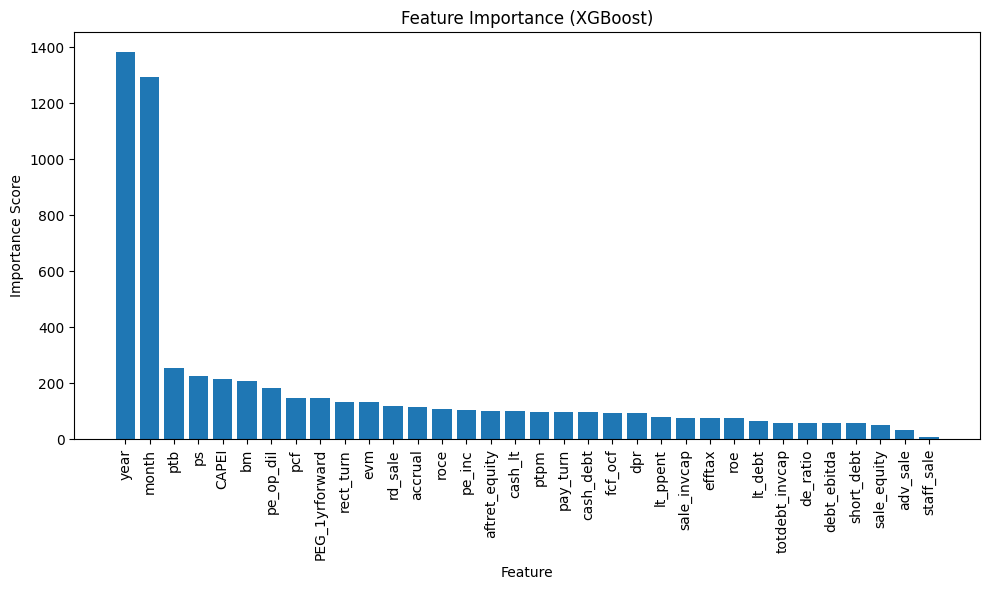

XGBoost Results (Unscaled)
RMSE: 11.0836
MAE: 7.9984


In [188]:
# Train and test the model
bst, y_pred_boost = XGBoost_Regression(train_X, train_y, test_X, test_y, feature_names=train_df.drop(columns=['trt1m', 'date']).columns.tolist(), plot_importance=True)


y_pred_unscaled_boost = target_scaler.inverse_transform(y_pred_boost.reshape(-1, 1))
y_test_unscaled_boost = target_scaler.inverse_transform(test_y.reshape(-1, 1))

# Compute metrics post inverse scaling
rmse_boost = np.sqrt(mean_squared_error(y_test_unscaled_boost, y_pred_unscaled_boost))
mae_boost = mean_absolute_error(y_test_unscaled_boost, y_pred_unscaled_boost)
print(f"XGBoost Results (Unscaled)")
print(f"RMSE: {rmse_boost:.4f}")
print(f"MAE: {mae_boost:.4f}")


### Random Forests

In [180]:
# Define the RF model
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(train_X.reshape(train_X.shape[0], train_X.shape[2]), train_y)

y_pred_rf = rf.predict(test_X.reshape(test_X.shape[0], test_X.shape[2]))

# Inverse transformation
y_pred_unscaled_rf = target_scaler.inverse_transform(y_pred_rf.reshape(-1, 1))
y_test_unscaled_rf = target_scaler.inverse_transform(test_y.reshape(-1, 1))

# Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test_unscaled_rf, y_pred_unscaled_rf))
mae_rf = mean_absolute_error(y_test_unscaled_rf, y_pred_unscaled_rf)
print(f"Random Forest Results (Unscaled)")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")


Random Forest Results (Unscaled)
RMSE: 12.0943
MAE: 9.0428


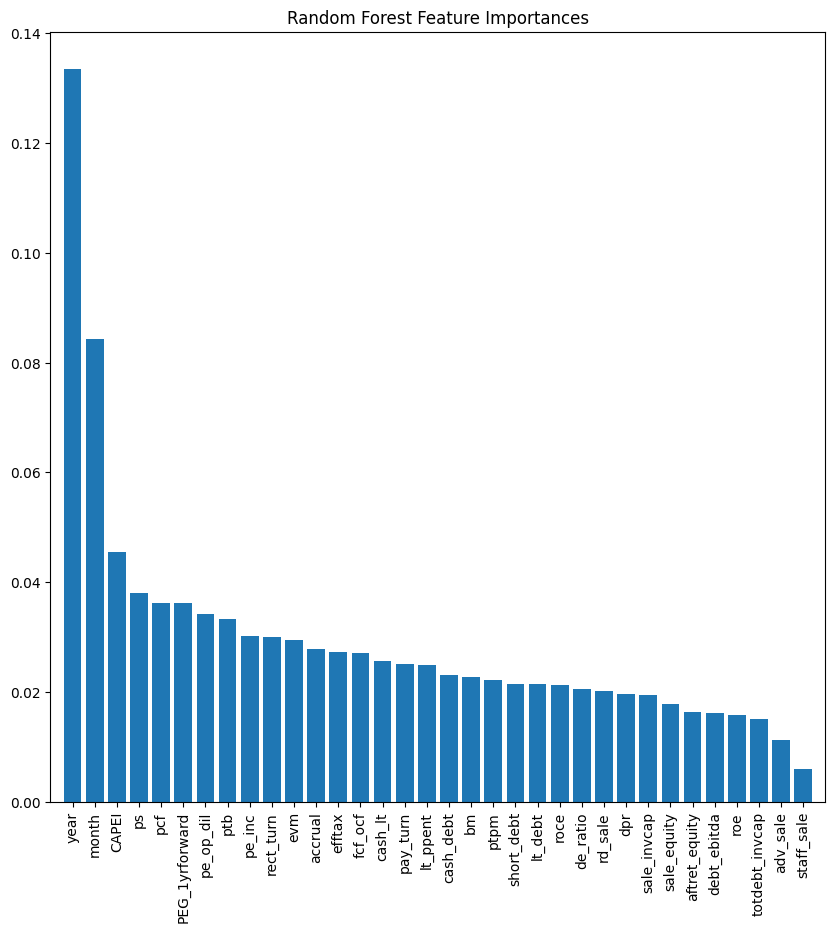

In [192]:
# Factor Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names=train_df.drop(columns=['trt1m', 'date']).columns
plt.figure(figsize=(10, 10))
plt.title("Random Forest Feature Importances")
plt.bar(range(train_X.shape[2]), importances[indices], align="center")
plt.xticks(range(train_X.shape[2]), feature_names[indices], rotation=90)
plt.xlim([-1, train_X.shape[2]])
plt.show()



#### LSTMs

In [193]:
n_features = train_X.shape[2]
n_neurons = int(5 * n_features)

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, n_features), return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [194]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_X, train_y,
                    epochs=50,
                    batch_size=64,
                    validation_data=(test_X, test_y),
                    callbacks=[early_stop],
                    shuffle=False,
                    verbose=2)

Epoch 1/50
2787/2787 - 6s - 2ms/step - loss: 0.6790 - mae: 0.6790 - val_loss: 0.7505 - val_mae: 0.7505
Epoch 2/50
2787/2787 - 5s - 2ms/step - loss: 0.6415 - mae: 0.6415 - val_loss: 0.7514 - val_mae: 0.7514
Epoch 3/50
2787/2787 - 5s - 2ms/step - loss: 0.6398 - mae: 0.6398 - val_loss: 0.7467 - val_mae: 0.7467
Epoch 4/50
2787/2787 - 5s - 2ms/step - loss: 0.6382 - mae: 0.6382 - val_loss: 0.7561 - val_mae: 0.7561
Epoch 5/50
2787/2787 - 5s - 2ms/step - loss: 0.6373 - mae: 0.6373 - val_loss: 0.7462 - val_mae: 0.7462
Epoch 6/50
2787/2787 - 5s - 2ms/step - loss: 0.6361 - mae: 0.6361 - val_loss: 0.7549 - val_mae: 0.7549
Epoch 7/50
2787/2787 - 5s - 2ms/step - loss: 0.6351 - mae: 0.6351 - val_loss: 0.7549 - val_mae: 0.7549
Epoch 8/50
2787/2787 - 6s - 2ms/step - loss: 0.6348 - mae: 0.6348 - val_loss: 0.7580 - val_mae: 0.7580
Epoch 9/50
2787/2787 - 5s - 2ms/step - loss: 0.6342 - mae: 0.6342 - val_loss: 0.7477 - val_mae: 0.7477
Epoch 10/50
2787/2787 - 5s - 2ms/step - loss: 0.6336 - mae: 0.6336 - val_

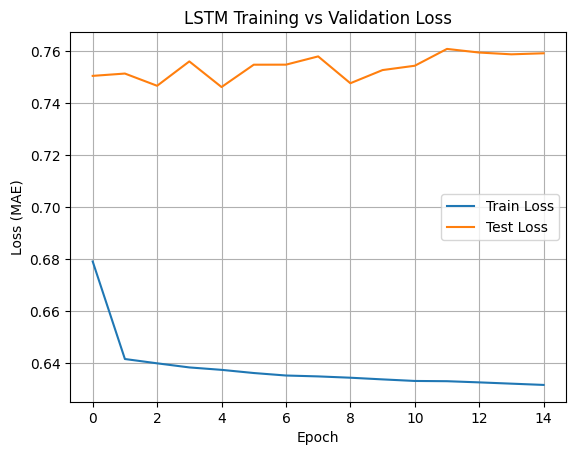

In [195]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [196]:
# Predict using the LSTM model
y_pred_lstm = model.predict(test_X)
# Inverse transform the predictions
y_pred_unscaled_lstm = target_scaler.inverse_transform(y_pred_lstm)
y_test_unscaled_lstm = target_scaler.inverse_transform(test_y.reshape(-1, 1))
# Compute metrics post inverse scaling
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled_lstm, y_pred_unscaled_lstm))
mae_lstm = mean_absolute_error(y_test_unscaled_lstm, y_pred_unscaled_lstm)
print(f"LSTM Results (Unscaled)")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step
LSTM Results (Unscaled)
RMSE: 11.3920
MAE: 8.2852


## Portfolio Metrics

In [197]:
pred_results = pd.DataFrame({
    'pred_lstm': y_pred_unscaled_lstm.flatten(),
    'pred_xgb': y_pred_unscaled_boost.flatten(),
    'actual': y_test_unscaled_lstm.flatten(),
    'date': test_df['date'].values,
    'stock_id': final_df.loc[test_df.index, 'permno'].values  # or 'stock_id' if you have one
})
pred_results


,pred_lstm,pred_xgb,actual,date,stock_id
0,2.538492,1.718306,-18.8586,2020-01-31,54594
1,2.954997,1.459862,-48.3792,2020-02-29,54594
2,4.363897,4.147373,10.2477,2020-03-31,54594
3,4.357291,-0.645140,3.0133,2020-04-30,54594
4,4.263172,4.049299,2.4789,2020-05-31,54594
...,...,...,...,...,...
44575,1.334689,1.249021,1.1229,2024-08-31,87445
44576,1.242415,0.881428,4.0351,2024-09-30,87445
44577,1.047230,3.243323,6.5756,2024-10-31,87445
44578,0.741102,1.411910,-4.3544,2024-11-30,87445


In [164]:
def build_portfolio(df, pred_col, long_frac=0.1, short_frac=0.1):
    portfolio_returns = []

    for date, group in df.groupby('date'):
        group = group.copy()
        group = group.sort_values(by=pred_col, ascending=False)

        n = len(group)
        long_n = int(n * long_frac)
        short_n = int(n * short_frac)

        long_ret = group.head(long_n)['actual'].mean()
        short_ret = group.tail(short_n)['actual'].mean()

        long_short = long_ret - short_ret
        portfolio_returns.append({
            'date': date,
            'long_ret': long_ret,
            'short_ret': short_ret,
            'long_short': long_short
        })

    return pd.DataFrame(portfolio_returns)

In [168]:
def evaluate_portfolio(portfolio_df, col='long_short', rf=0.0):
    returns = portfolio_df[col].values

    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (avg_return - rf) / std_dev * np.sqrt(12)  # monthly to annual

    ann_return = (1 + avg_return) ** 12 - 1
    ann_volatility = std_dev * np.sqrt(12)

    return {
        'Sharpe Ratio': sharpe_ratio
    }

In [169]:
lstm_portfolio = build_portfolio(pred_results, pred_col='pred_lstm')
xgb_portfolio = build_portfolio(pred_results, pred_col='pred_xgb')

lstm_metrics = evaluate_portfolio(lstm_portfolio)
xgb_metrics = evaluate_portfolio(xgb_portfolio)

print("LSTM Portfolio Metrics:", lstm_metrics)
print("XGBoost Portfolio Metrics:", xgb_metrics)

LSTM Portfolio Metrics: {'Sharpe Ratio': np.float64(0.6694111321388122)}
XGBoost Portfolio Metrics: {'Sharpe Ratio': np.float64(1.0518120518019303)}
